# Keyword detection demo for collab

This notebook can be used to record live audio and running keyword detection for pretrained model.
The keyword used is **ALINA** (russian name).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AndBondStyle/wavenet-keyword-spotting/blob/master/notebooks/colab_demo.ipynb)

In [1]:
!apt update && apt install python3-pyaudio
!pip install git+https://github.com/AndBondStyle/wavenet-keyword-spotting
!wget https://github.com/AndBondStyle/wavenet-keyword-spotting/releases/download/v1/v1.final.pt
!pip install ipympl

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [2]:
from wavenet_kws.detection import KeywordDetector

import IPython.display as ipd
import matplotlib.pyplot as plt
from google.colab import output
from base64 import b64decode
from tqdm.auto import tqdm
import subprocess as sp
import numpy as np
import librosa
import torch

In [3]:
RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async () => {
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record_audio(duration, sample_rate=16000):
    print(f"Recording browser mic for {duration} seconds...")
    ipd.display(ipd.Javascript(RECORD))
    raw_out = output.eval_js(f"record({duration * 1000})")
    print("Finished recording")
    buffer = b64decode(raw_out.split(",")[1])
    with open('input.raw', 'wb') as file:
        file.write(buffer)
    cmd = f"ffmpeg -i input.raw -ac 1 -ar {sample_rate} -y output.wav"
    sp.check_output(cmd, shell=True)
    sig, _ = librosa.load("output.wav", sr=sample_rate)
    return sig

# Record audio:

In [13]:
audio = record_audio(duration=10, sample_rate=16000)
print("Recorded audio:")
ipd.display(ipd.Audio(audio, rate=16000))

Recording browser mic for 10 seconds...


<IPython.core.display.Javascript object>

Finished recording
Recorded audio:


# Run detection:

Loading model...
Processing audio...


  0%|          | 0/623 [00:00<?, ?it/s]

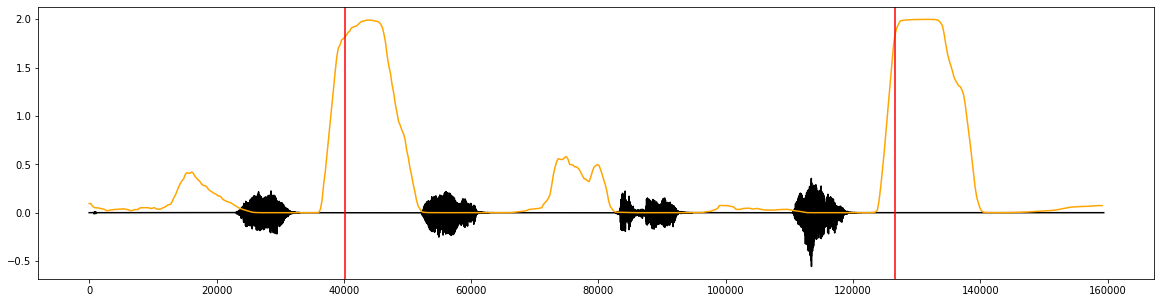

In [14]:
CHECKPOINT = "v1.final.pt"  # Path to model checkpoint
SMOOTHING = 10              # Rolling window smoothing
THRESHOLD = 0.9             # Sensitivity threshold
TIMEOUT = 1.0               # Miminum delay between triggers (in seconds)


print("Loading model...")
detector = KeywordDetector(
    checkpoint=CHECKPOINT,
    threshold=THRESHOLD,
    smoothing=SMOOTHING,
)

print("Processing audio...")
chunk_size = detector.config.fft_window_step
predictions = []
trigger_cooldown = 0
timeout = int(sample_rate * TIMEOUT)
for i in tqdm(range(0, len(audio), chunk_size)):
    chunk = audio[i:i + chunk_size]
    detector.push_audio(chunk)
    pred = detector.predict()
    if pred is not None:
        level, trigger = pred
        if trigger and i < trigger_cooldown:
            trigger = False
        if trigger:
            trigger_cooldown = i + timeout
        predictions.append((level, trigger))

levels = np.array([x[0] for x in predictions])
triggers = [i for i, x in enumerate(predictions) if x[1]]
x_range = np.arange(0, len(audio), len(audio) / len(predictions))
fig = plt.figure(figsize=(20, 5))
plt.plot(audio, c='black')
plt.plot(x_range, levels * 2, c='orange')
for trigger in triggers:
    x = x_range[trigger]
    plt.axvline(x=x, c='red')
plt.show()